<a href="https://colab.research.google.com/github/quent1fvr/Infection_pulmonaire/blob/main/pre_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0 - Importation des données et librairies**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import zipfile
import os
import argparse
import imutils
import cv2
import shutil
import h5py
import PIL
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
from keras.preprocessing.image import load_img, img_to_array, array_to_img

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/UV PROJET P6/COVID_dataset.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/tmp') # Extracts the files into the /tmp folder
A = zip_ref.close()

# **I - Etude de la distribution des données brutes**

### I - 1. Code pour la visualisation générale du jeu de données

In [ ]:
def visualisation(infoGen, camembert, histogr, infoMoy):
  
  tab_normal = []
  tab_malade = []
  nb_img_total = 0
  nb_img_normal = 0
  nb_img_malade = 0
  path_normal = '/tmp/COVID_crop/normal'
  path_malade = '/tmp/COVID_crop/malade'

  for base in os.walk(path_normal):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_normal.append(len(base[2]))
    nb_img_total += len(base[2])
    nb_img_normal += len(base[2])
  tab_normal.pop(0)
  tab_normal.sort()

  for base in os.walk(path_malade):
    #print('folder "', base[0], '" containing ', len(base[2]), ' files')
    tab_malade.append(len(base[2]))
    nb_img_total += len(base[2])    
    nb_img_malade += len(base[2])
  tab_malade.pop(0)
  tab_malade.sort()

  if infoGen == True:
    print("\n---------- Infos générales ----------\n")
    print('Nombre de scans cas "normale" :', len(os.listdir('/tmp/COVID_crop/normal')))
    print('Nombre de scans cas "malade" :', len(os.listdir('/tmp/COVID_crop/malade')))
    print('''\nNombre d'images cas "normal" :''', nb_img_normal)
    print('''Nombre d'images cas "malade" :''', nb_img_malade)
    print('''Nombre d'images total :''', nb_img_total)

  if camembert == True:
    print("\n---------- Camembert ----------\n")
    x = np.array([len(os.listdir(path_normal)), len(os.listdir(path_malade))])
    labels = ['normal', 'malade']
    colors = {'normal': 'chartreuse','malade': 'teal' }
    plt.pie(x, labels=labels, autopct='%.0f%%', radius=0.8, colors=[colors[key] for key in labels], textprops={'fontsize': 18})
    plt.show()

  if histogr == True:
    print("\n---------- Histogramme ----------\n")
    plt.figure(figsize=(20, 10))
    x0 = tab_normal
    x1 = tab_malade
    plt.hist(x0, alpha=0.5, label="Distribution du nombre d'images par scan normal")
    plt.hist(x1, alpha=0.5, label="Distribution du nombre d'images par scan malade")
    plt.legend(loc='lower right')
    plt.xlabel("Nombres d'images par scan")
    plt.ylabel("Occurences")
    plt.show()

  if infoMoy == True:
    print("\n---------- Infos sur les moyennes ----------\n")
    x0_mean = np.mean(tab_normal)
    x1_mean = np.mean(tab_malade)
    tot_mean = (nb_img_normal/nb_img_total)*x0_mean + (nb_img_malade/nb_img_total)*x1_mean
    print('''Moyenne d'images pour les scans cas "normal" :''', x0_mean)
    print('''Moyenne d'images pour les scans cas "malade" :''', x1_mean)
    print('''Moyenne d'images pour tous les scans confondus :''', tot_mean)

### I - 2. Analyse du jeu de données "brutes"


---------- Infos générales ----------

Nombre de scans cas "normale" : 1078
Nombre de scans cas "malade" : 1544

Nombre d'images cas "normal" : 95756
Nombre d'images cas "malade" : 156071
Nombre d'images total : 251827

---------- Camembert ----------



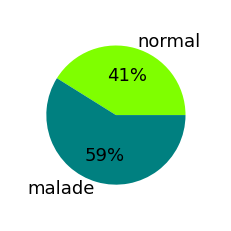


---------- Histogramme ----------



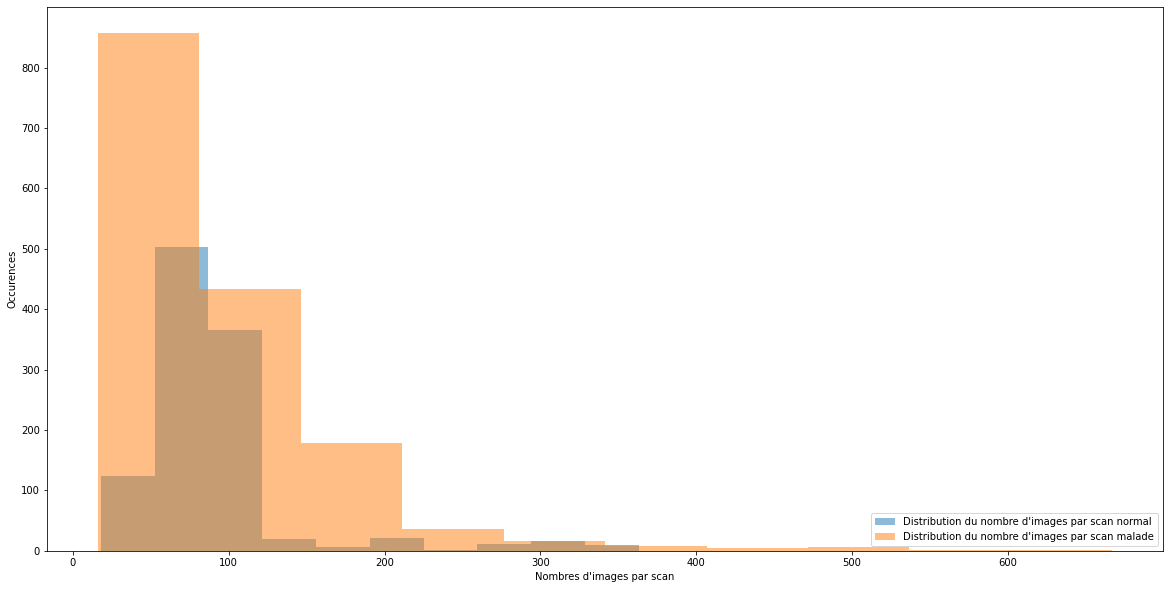


---------- Infos sur les moyennes ----------

Moyenne d'images pour les scans cas "normal" : 88.82745825602969
Moyenne d'images pour les scans cas "malade" : 101.08225388601036
Moyenne d'images pour tous les scans confondus : 96.42242705908383


In [ ]:
visualisation(True, True, True, True)

Selon cette première visualisation du jeu de données "brutes", nous remarquons plusieurs points sur lequels nous pouvons travailler afin d'obtenir un jeu  plus lisible pour l'algorithme de deep learning que nous implémenterons par la suite. En effet, selon l'histogramme regroupant l'ensemble des scans de personnes malades et normales, nous pouvons observer : 

1. D'une part, une distribution du nombre d'images par scan assez étalée avec des cas extrêmes inexploitables à ignorer : ~10 ou +600 images par scan
2. D'autre part, une moyenne du nombre d'images par scan différente et non précise pour les deux cas :
  *   🤒 "malade" avec 2 pics d'occurences pour des scans contenant ~60 et ~140 images
  *   🙂 "normal" avec des pics aux alentours de 90 images par scan

Ainsi, nous allons réaliser dans ***II.Padding des données*** un nettoyage et une standardisation du jeu de données pour permettre d'une part un traitement plus aisé, et d'autre part de réduire le poids de stockage. Nous aimerions ainsi obtenir un nombre fixé d'images par scan quelque soit le cas, pour tous les scans du jeu de données.

# **II - Padding des données**

Premièrement nous avons estimé que les scans de moins de 40 et plus de 100 images sont à éliminer.

### II - 1. On élimine les scans contenant moins de 40 et plus de 100 images


In [ ]:
num_skipped = 0
for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if len(os.listdir(fpath)) >= 100 or len(os.listdir(fpath)) <= 40:
      num_skipped += 1
      shutil.rmtree(fpath)
print("Deleted %d scans" % num_skipped)

Deleted 1046 scans



---------- Infos générales ----------

Nombre de scans cas "normale" : 796
Nombre de scans cas "malade" : 780

Nombre d'images cas "normal" : 62207
Nombre d'images cas "malade" : 44436
Nombre d'images total : 106643

---------- Histogramme ----------



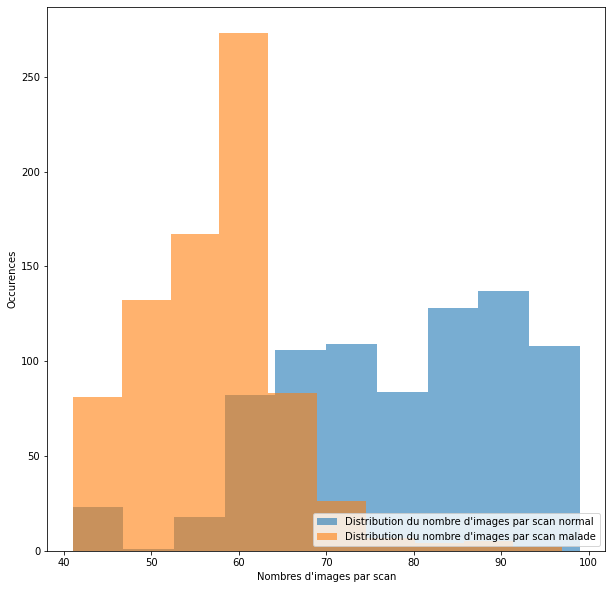


---------- Infos sur les moyennes ----------

Moyenne d'images pour les scans cas "normal" : 78.14949748743719
Moyenne d'images pour les scans cas "malade" : 56.96923076923077
Moyenne d'images pour tous les scans confondus : 69.32410499200645


In [ ]:
visualisation(True, False, True, True)

Suite à cette première opération sur les données nous avons réussi à borner le nombre d'images par scan entre 40 et 100, comme le montre l'histogramme. De plus, la moyenne d'images obtenue par scan (tous cas confondus) se situe aux alentours de 70 images. Ainsi, cela nous donne une ligne directrice pour les prochaines opérations de normalisation du set à réaliser : nous avons décidé de normaliser le nombre d'images par scan à 70. Pour se faire, deux opérations supplémentaires sur le set sont à réaliser : 
1.   Réduire le nombre d'images dans les scans en contenant plus de 70 
2.   Augmenter le nombre d'images pour ceux en contenant moins de 70



### II - 2. On comble les scans contenant moins de 70 images ▶ Choix à faire

#### II - 2.1. Méthode 1 : Comble par ajouts d'images noires à la fin

In [ ]:
num_skipped = 0
from PIL import Image
for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if len(os.listdir(fpath)) < 70:
      for i in range (70 - len(os.listdir(fpath))) : 
        new_im = Image.new('RGB', (128, 128), (0, 0, 0))
        new_im.save(fpath + "/Dark_image" + str(i), "PNG")

In [ ]:
visualisation(True, False, False, True)

#### II - 2.2. Méthode 2 : Comble par copie d'images en partant du milieu du scan

In [ ]:
def pathImg(index_img):
  if index_img < 10:
    return fpath + "/000" + str(index_img) + ".png"
  else:
    return fpath + "/00" + str(index_img) + ".png"

for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    compteur_img_toAdd = 70 - len(os.listdir(fpath))
    if len(os.listdir(fpath)) < 70:

      # ---------- choix index image1 à copier ----------
      # méthode : choix au milieu du scan
      index_img1 = len(os.listdir(fpath))//2
      while os.path.exists(pathImg(index_img1)) == False:
        index_img1 += 1
      else:
        path_img1 = pathImg(index_img1)
        compteur_img_toAdd -= 1
        #path_img2 = path_img1[:-6] + str(int(path_img1[len(path_img1)-6: -4]) + 2) + ".png"
        path_img2 = fpath + "/New_image" + str(70 - compteur_img_toAdd) + ".png"
        shutil.copy2(path_img1, path_img2)
        print("New image added : ", path_img2)

        # ---------- choix index imageSuivante à copier ----------
        # méthode : choix au index [imagePrecedente + 2] s'il existe
        while compteur_img_toAdd != 0:
          index_img1 += 2
          while (os.path.exists(pathImg(index_img1)) == False) and (index_img1 < 100):
            index_img1 += 1
          else:
            if index_img1 >= 100: # si l'index dépasse 100 on repart à un index de 40
              index_img1 = 40
              while (os.path.exists(pathImg(index_img1)) == False):
                index_img1 += 1
            else:
              index_img1
            path_img1 = pathImg(index_img1)
            compteur_img_toAdd -= 1
            #path_img2 = path_img1[:-6] + str(int(path_img1[len(path_img1)-6: -4]) + 2) + ".png"
            path_img2 = fpath + "/New_image" + str(70 - compteur_img_toAdd) + ".png"
            shutil.copy2(path_img1, path_img2)
            #print("New image added : ", path_img2)
          

In [ ]:
visualisation(True, False, False, True)


---------- Infos générales ----------

Nombre de scans cas "normale" : 796
Nombre de scans cas "malade" : 780

Nombre d'images cas "normal" : 64146
Nombre d'images cas "malade" : 54849
Nombre d'images total : 118995

---------- Infos sur les moyennes ----------

Moyenne d'images pour les scans cas "normal" : 80.58542713567839
Moyenne d'images pour les scans cas "malade" : 70.31923076923077
Moyenne d'images pour tous les scans confondus : 75.85337449058166


#### II - 2.3. Méthode 3 : Comble par ajouts d'images noires en début & fin de scan

In [ ]:
num_skipped = 0
from PIL import Image
for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if len(os.listdir(fpath)) < 70:
      for i in range (70 - len(os.listdir(fpath))) : 
        new_im = Image.new('RGB', (128, 128), (0, 0, 0))
        new_im.save(fpath + "/Dark_image" + str(i), "PNG")

### II - 3. On élimine des images dans les scans contenant plus de 70 image ▶ Choix à faire

#### II - 3.1. Méthode 1 : Elimination aléatoire

In [ ]:
for folder_name in ("normal", "malade"):
    folder_path = os.path.join("/tmp/COVID_crop", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if len(os.listdir(fpath)) > 70:
            while len(os.listdir(fpath)) !=70 :
                delete_path = fpath + "/00" + str(np.random.randint(10,len(os.listdir(fpath)))) + ".png"
                while os.path.exists(delete_path):  
                    os.remove(delete_path)

In [ ]:
visualisation(True, False, False, True)

#### II - 3.2. Méthode 2 : Elimination par comparaison SSIM

In [ ]:
def pathImg(index_img):
  if index_img < 10:
    return fpath + "/000" + str(index_img) + ".png"
  else:
    return fpath + "/00" + str(index_img) + ".png"

for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    if len(os.listdir(fpath)) > 70:
      compteur_img_toDel = len(os.listdir(fpath)) - 70
      while compteur_img_toDel != 0:

        # ---------- choix des images à comparer ----------
        
        # choix index image1
        # sachant que les images sont numérotées entre 0001 et 0***
        # méthode : choix random de l'index
        
        index_img1 = np.random.randint(1, len(os.listdir(fpath)) - 1)
        while os.path.exists(pathImg(index_img1)) == False:
          index_img1 = np.random.randint(1, len(os.listdir(fpath)) - 1)
        else:
          path_img1 = pathImg(index_img1)

        # choix index image2
        # sachant qu'elle doit être la plus proche voisine de l'image1
        # méthode : recherche de l'index le plus proche supérieur
        
        index_img2 = index_img1 + 1                
        while os.path.exists(pathImg(index_img2)) == False:
          index_img2 += 1
        else:
          path_img2 = pathImg(index_img2)

        # ------------- comparaison des 2 images successives -------------
        
        image1 = cv2.imread(path_img1)
        image2 = cv2.imread(path_img2)
        #print("\nImage1\nPath : ", path_img1, "\nShape : ", image1.shape)
        #print("Image2\nPath : ", path_img2, "\nShape : ", image2.shape, "\n")
        (score, diff) = compare_ssim(image1, image2, full=True, multichannel=True)
        diff = (diff * 255).astype("uint8")
        #print(fpath, compteur_img_toDel, "SSIM: {}".format(score))

        # ---------- suppression de l'image1 ----------
        
        # critère : SSIM > 0.80 (images très similaires)
        if score > 0.80 and compteur_img_toDel != 0 :
          compteur_img_toDel -= 1
          while os.path.exists(path_img1):
            os.remove(path_img1)

In [ ]:
visualisation(True, False, False, True)


---------- Infos générales ----------

Nombre de scans cas "normale" : 796
Nombre de scans cas "malade" : 780

Nombre d'images cas "normal" : 55720
Nombre d'images cas "malade" : 54600
Nombre d'images total : 110320

---------- Infos sur les moyennes ----------

Moyenne d'images pour les scans cas "normal" : 70.0
Moyenne d'images pour les scans cas "malade" : 70.0
Moyenne d'images pour tous les scans confondus : 70.0


Cette méthode de suppression par comparaison SSIM fonctionne correctement, cependant suite à des essais nous avons remarqué un écueil. Selon ce critère, des images toutes noires obtiennent un score de similarité supérieur, lorsqu'elles sont comparées avec des images de poumon "moyennes", à deux images "moyennes" comparées entre elles.

##### II - 3.2.1 Détails et explications de la comparaison SSIM

The score represents the structural similarity index between the two input images. This value can fall into the range [-1, 1] with a value of one being a “perfect match”.

The diff image contains the actual image differences between the two input images that we wish to visualize. The difference image is currently represented as a floating point data type in the range [0, 1] so we first convert the array to 8-bit unsigned integers in the range [0, 255] (Line 26) before we can further process it using OpenCV.

------------- comparaison images "noire/poumon" -------------

SSIM (Score of similarity): 0.7323755563374182

Image "noire" :



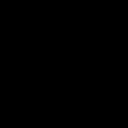


Image "poumon" :



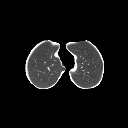


Différence :



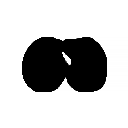

------------- comparaison images "poumon/poumon" 1 -------------

SSIM (Score of similarity): 0.7566269570883225

Image "poumon 1" :



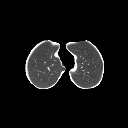


Image "poumon 2" :



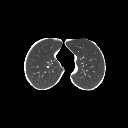


Différence :



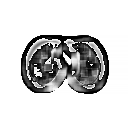

------------- comparaison images "poumon/poumon" 2 -------------

SSIM (Score of similarity): 0.7211043004327471

Image "poumon 1" :



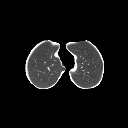


Image "poumon 3" :



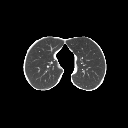


Différence :



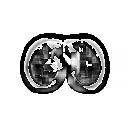

In [ ]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from PIL import Image
from google.colab.patches import cv2_imshow

path_image1 = "/tmp/COVID_crop/normal/1/0002.png"
path_image2 = "/tmp/COVID_crop/normal/1/0015.png"
path_image3 = "/tmp/COVID_crop/normal/1/0017.png"
path_image4 = "/tmp/COVID_crop/normal/1/0018.png"

# chargement des images
image1 = cv2.imread(path_image1)
image2 = cv2.imread(path_image2)
image3 = cv2.imread(path_image3)
image4 = cv2.imread(path_image4)

print('''------------- comparaison images "noire/poumon" -------------''')

# calcul du "Structural Similarity Index (SSIM)" entre 2 images et retour de la différence en pixels
(score, diff) = compare_ssim(image1, image2, full=True, multichannel=True)
diff = (diff * 255).astype("uint8")
print("\nSSIM (Score of similarity): {}".format(score))

# affichage des images
print('''\nImage "noire" :\n''')
#img = load_img(path_image1, target_size=(48,48))   
#load_img.show()
cv2_imshow(image1)
print('''\nImage "poumon" :\n''')
cv2_imshow(image2)
print("\nDifférence :\n")
cv2_imshow(diff)

print('''------------- comparaison images "poumon/poumon" 1 -------------''')

# calcul du "Structural Similarity Index (SSIM)" entre 2 images et retour de la différence en pixels
(score1, diff1) = compare_ssim(image2, image3, full=True, multichannel=True)
diff1 = (diff1 * 255).astype("uint8")
print("\nSSIM (Score of similarity): {}".format(score1))

# affichage des images
print('''\nImage "poumon 1" :\n''')
cv2_imshow(image2)
print('''\nImage "poumon 2" :\n''')
cv2_imshow(image3)
print("\nDifférence :\n")
cv2_imshow(diff1)

print('''------------- comparaison images "poumon/poumon" 2 -------------''')

# calcul du "Structural Similarity Index (SSIM)" entre 2 images et retour de la différence en pixels
(score2, diff2) = compare_ssim(image2, image4, full=True, multichannel=True)
diff2 = (diff2 * 255).astype("uint8")
print("\nSSIM (Score of similarity): {}".format(score2))

# affichage des images
print('''\nImage "poumon 1" :\n''')
cv2_imshow(image2)
print('''\nImage "poumon 3" :\n''')
cv2_imshow(image4)
print("\nDifférence :\n")
cv2_imshow(diff2)

# **III - Conversion des images en niveau de gris**

Une fois le padding des données réalisé, on transforme les images en niveaux de gris, à la fois pour que l'architecture de notre modèle de deep learning soit plus simple et aussi pour limiter la taille des fichiers.

In [ ]:
for folder_name in ("normal", "malade"):
  folder_path = os.path.join("/tmp/COVID_crop", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    for fimg in os.listdir(fpath): 
      img_path = os.path.join(fpath,fimg)
      img = Image.open(img_path)
      imgGray = img.convert('L')
      imgGray.save(img_path, "PNG")

# **IV - Conversion des données normalisées en hdf5**



On sauvegarde à présent notre jeu de données pré-traité au format hdf5 pour l'exploiter ensuite par notre modèle deep. 

In [ ]:
# conversion des images 128*128 en array numpy binaire d'images en 48*48
arrlist_normal = []
folder_path = os.path.join("/tmp/COVID_crop", "normal")
for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    for imgs in os.listdir(fpath):
      array = np.array(Image.open(fpath + "/" + imgs).resize((48, 48))) / 255
      arrlist_normal.append(array)          

arrlist_malade = []
folder_path = os.path.join("/tmp/COVID_crop", "malade")
for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    for imgs in os.listdir(fpath):
      array = np.array(Image.open(fpath + "/" + imgs).resize((48, 48))) / 255
      arrlist_malade.append(array)  

In [ ]:
# écriture du dataset "normal" en un fichier ".hdf5" à partir de l'array correspondante créée précédemment
h5f = h5py.File('/content/drive/MyDrive/UV PROJET P6/dataset_normal_methode_2.2_3.2.hdf5', 'w')
h5f.create_dataset('dataset_1', data=arrlist_normal)
h5f.close()

In [ ]:
# écriture du dataset "malade" en un fichier ".hdf5" à partir de l'array correspondante créée précédemment
h5f1 = h5py.File('/content/drive/MyDrive/UV PROJET P6/dataset_malade_methode_2.2_3.2.hdf5', 'w')
h5f1.create_dataset('dataset_2', data=arrlist_malade)
h5f1.close()